In [41]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
CUDA = True
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64

D_HIDDEN = 64
EPOCH_NUM = 100
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [3]:
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.2.2
CUDA version: 12.1



In [4]:
# Data preprocessing
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

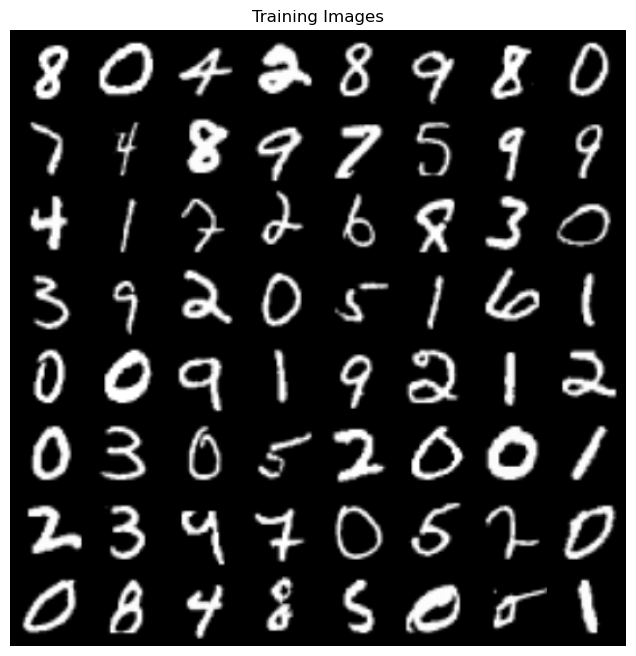

In [5]:
# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)

In [36]:
# Create the generator
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [37]:
# Create the discriminator
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [38]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

g_losses = []
d_losses = []

In [49]:
for epoch in range(EPOCH_NUM):
    g_loss_epoch = 0
    d_loss_epoch = 0
    
    for i, data in enumerate(dataloader, 0):
        batch_size = data[0].size(0)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        discriminator.zero_grad()
        
        # Train with real images
        real_images = data[0].to(device)
        real_labels = torch.ones(batch_size, 1).to(device) * 0.9  # Label smoothing
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        d_real_output = discriminator(real_images)
        d_real_loss = criterion(d_real_output, real_labels)
        d_real_loss.backward()
        
        # Train with fake images
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = generator(noise)
        d_fake_output = discriminator(fake_images.detach())  # Detach to avoid training G
        d_fake_loss = criterion(d_fake_output, fake_labels)
        d_fake_loss.backward()
        
        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) * 0.5  # Average the losses
        optimizerD.step()
        
        # -----------------
        #  Train Generator
        # -----------------
        generator.zero_grad()
        
        # Generate new fake images
        noise = torch.randn(batch_size, 100, 1, 1, device=device)  # New noise
        fake_images = generator(noise)
        g_output = discriminator(fake_images)
        g_loss = criterion(g_output, real_labels)
        g_loss.backward()
        optimizerG.step()
        
        # Save losses
        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()
        
        # Print batch progress
        if i % 100 == 0:
            print(f'[{epoch}/{EPOCH_NUM}][{i}/{len(dataloader)}] '
                  f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')
    
    # Calculate average epoch losses
    g_losses.append(g_loss_epoch/len(dataloader))
    d_losses.append(d_loss_epoch/len(dataloader))
    
    # Print epoch stats
    print(f'Epoch [{epoch}/{EPOCH_NUM}] '
          f'D_loss: {d_loss_epoch/len(dataloader):.4f} '
          f'G_loss: {g_loss_epoch/len(dataloader):.4f}')
    
    # Generate and save sample images
    if epoch % 5 == 0:
        with torch.no_grad():
            generator.eval()
            n = torch.randn(16, 100, 1, 1).cuda()
            random_samples = generator(n).view(16, 1, 64, 64)
            grid = make_grid(random_samples.cpu(), nrow=4, normalize=True)
            plt.figure(figsize=(10, 10))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis('off')
            plt.title(f'Generated Images at Epoch {epoch}', fontsize=15)
            plt.savefig(f'generated_images_epoch_{epoch}.png', 
                       bbox_inches='tight', pad_inches=0.1)
            plt.close()
            generator.train()

# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.savefig('training_losses.png')
plt.close()

[0/100][0/469] D_loss: 0.6855 G_loss: 41.2953
[0/100][100/469] D_loss: 50.1678 G_loss: 10.0000
[0/100][200/469] D_loss: 50.1662 G_loss: 10.0000
[0/100][300/469] D_loss: 50.1675 G_loss: 10.0000
[0/100][400/469] D_loss: 50.1638 G_loss: 10.0000
Epoch [0/100] D_loss: 46.8368 G_loss: 11.7852
[1/100][0/469] D_loss: 0.1776 G_loss: 5.0382
[1/100][100/469] D_loss: 0.8009 G_loss: 0.7601
[1/100][200/469] D_loss: 0.2975 G_loss: 3.0163
[1/100][300/469] D_loss: 0.3595 G_loss: 2.6126
[1/100][400/469] D_loss: 0.2250 G_loss: 4.4050
Epoch [1/100] D_loss: 0.4028 G_loss: 3.3097
[2/100][0/469] D_loss: 0.1990 G_loss: 3.3547
[2/100][100/469] D_loss: 0.2321 G_loss: 2.5052
[2/100][200/469] D_loss: 0.1886 G_loss: 3.3052
[2/100][300/469] D_loss: 0.2233 G_loss: 3.1052
[2/100][400/469] D_loss: 0.1825 G_loss: 3.6438
Epoch [2/100] D_loss: 0.3241 G_loss: 3.2828
[3/100][0/469] D_loss: 0.2063 G_loss: 3.1799
[3/100][100/469] D_loss: 0.1895 G_loss: 4.0047
[3/100][200/469] D_loss: 0.1989 G_loss: 3.5601
[3/100][300/469] D_

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.legend()
plt.title('Final GAN Training Results')
plt.show()